In [1]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import xarray as xr
from PyQt5.QtCore.QByteArray import length
from numpy.ma.core import shape

warnings.filterwarnings("ignore", module="scipy")

print(f"Running on PyMC v{pm.__version__}")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


ModuleNotFoundError: No module named 'PyQt5.QtCore.QByteArray'; 'PyQt5.QtCore' is not a package

In [2]:
RANDOM_SEED = 8924
az.style.use("arviz-darkgrid")

In [3]:
try:
    srrs2 = pd.read_csv(os.path.join("..", "data", "srrs2.dat"))
except FileNotFoundError:
    srrs2 = pd.read_csv(pm.get_data("srrs2.dat"))

srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state == "MN"].copy()

In [4]:
try:
    cty = pd.read_csv(os.path.join("..", "data", "cty.dat"))
except FileNotFoundError:
    cty = pd.read_csv(pm.get_data("cty.dat"))

srrs_mn["fips"] = srrs_mn.stfips * 1000 + srrs_mn.cntyfips
cty_mn = cty[cty.st == "MN"].copy()
cty_mn["fips"] = 1000 * cty_mn.stfips + cty_mn.ctfips

In [5]:
srrs_mn = srrs_mn.merge(cty_mn[["fips", "Uppm"]], on="fips")
srrs_mn = srrs_mn.drop_duplicates(subset="idnum")
u = np.log(srrs_mn.Uppm).unique()

n = len(srrs_mn)

In [6]:
srrs_mn.county = srrs_mn.county.map(str.strip)
county, mn_counties = srrs_mn.county.factorize()
srrs_mn["county_code"] = county
radon = srrs_mn.activity
srrs_mn["log_radon"] = log_radon = np.log(radon + 0.1).values
floor_measure = srrs_mn.floor.values

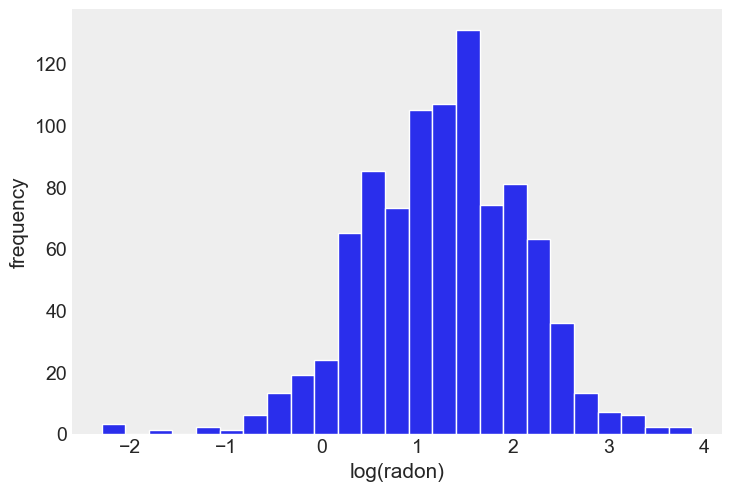

In [7]:
srrs_mn.log_radon.hist(bins=25, grid=False)
plt.xlabel("log(radon)")
plt.ylabel("frequency");

In [8]:
coords = {"county": mn_counties}

with pm.Model(coords=coords) as varying_intercept_slope:
    floor_idx = pm.MutableData("floor_idx", floor_measure, dims="obs_id")
    county_idx = pm.MutableData("county_idx", county, dims="obs_id")

    # Priors
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=10.0)
    sigma_a = pm.Exponential("sigma_a", 1)

    mu_b = pm.Normal("mu_b", mu=0.0, sigma=10.0)
    sigma_b = pm.Exponential("sigma_b", 1)

    # Random intercepts
    alpha = pm.Normal("alpha", mu=mu_a, sigma=sigma_a, dims="county")
    # Random slopes
    beta = pm.Normal("beta", mu=mu_b, sigma=sigma_b, dims="county")

    # Model error
    sigma_y = pm.Exponential("sigma_y", 1)

    # Expected value
    y_hat = alpha[county_idx] + beta[county_idx] * floor_idx

    # Data likelihood
    y_like = pm.Normal("y_like", mu=y_hat, sigma=sigma_y, observed=log_radon, dims="obs_id")

F:\anaconda\envs\pymc_env\Lib\site-packages\pymc\data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


In [9]:
with varying_intercept_slope:
    varying_intercept_slope_trace = pm.sample(tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, mu_b, sigma_b, alpha, beta, sigma_y]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 42 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


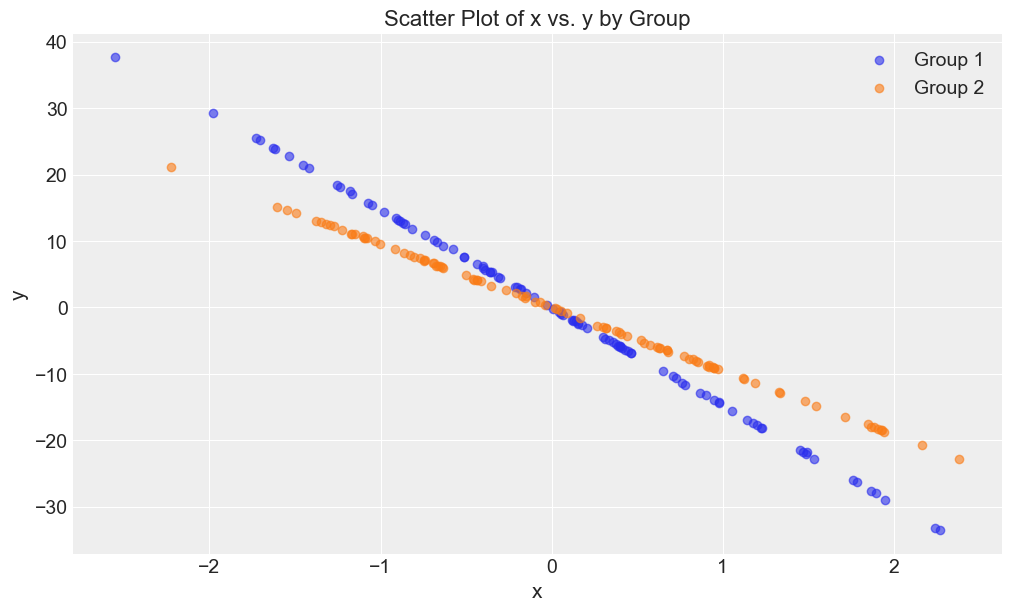

In [10]:
# Set random seed for reproducibility
np.random.seed(0)

# Number of samples and number of components
n_samples = 200
num_components = 2

# Generate the predictor variable x
x = np.random.normal(0, np.sqrt(1), n_samples)

# Initialize the response variable y
y = np.zeros(n_samples)

# Generate random betas (coefficients)
betas = np.random.normal(0, 40, num_components)

# Create group labels
groups = np.zeros(n_samples)

# Apply the different betas for every 100 samples and add random noise
for i in range(num_components):
    start_idx = i * 100
    end_idx = (i + 1) * 100
    y[start_idx:end_idx] = x[start_idx:end_idx] * betas[i] + np.random.normal(0, 0.1, 100)
    groups[start_idx:end_idx] = i

# Create a scatter plot, color-coded by group
plt.figure(figsize=(10, 6))
for i in range(num_components):
    group_idx = groups == i
    plt.scatter(x[group_idx], y[group_idx], label=f'Group {i+1}', alpha=0.6)

# Add plot labels and legend
plt.title('Scatter Plot of x vs. y by Group')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


# Gaussian Mixture Regression with GMR

In [4]:
import numpy as np
from gmr import GMM

# Your dataset as a NumPy array of shape (n_samples, n_features):
X = np.random.randn(100, 2)

gmm = GMM(n_components=3, random_state=0)
gmm.from_samples(X)

# Estimate GMM with expectation maximization:
X_sampled = gmm.sample(100)

# Make predictions with known values for the first feature:
x1 = np.random.randn(20, 1)
x1_index = [0]
x2_predicted_mean = gmm.predict(x1_index, x1)

<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:42: SyntaxWarning: invalid escape sequence '\S'
<>:43: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:42: SyntaxWarning: invalid escape sequence '\S'
<>:43: SyntaxWarning: invalid escape sequence '\m'
C:\Users\10191\AppData\Local\Temp\ipykernel_18556\211232875.py:25: SyntaxWarning: invalid escape sequence '\m'
  plt.title("Linear: $p(Y | X) = \mathcal{N}(\mu_{Y|X}, \Sigma_{Y|X})$")
C:\Users\10191\AppData\Local\Temp\ipykernel_18556\211232875.py:42: SyntaxWarning: invalid escape sequence '\S'
  plt.title("Mixture of Experts: $p(Y | X) = \Sigma_k \pi_{k, Y|X} "
C:\Users\10191\AppData\Local\Temp\ipykernel_18556\211232875.py:43: SyntaxWarning: invalid escape sequence '\m'
  "\mathcal{N}_{k, Y|X}$")


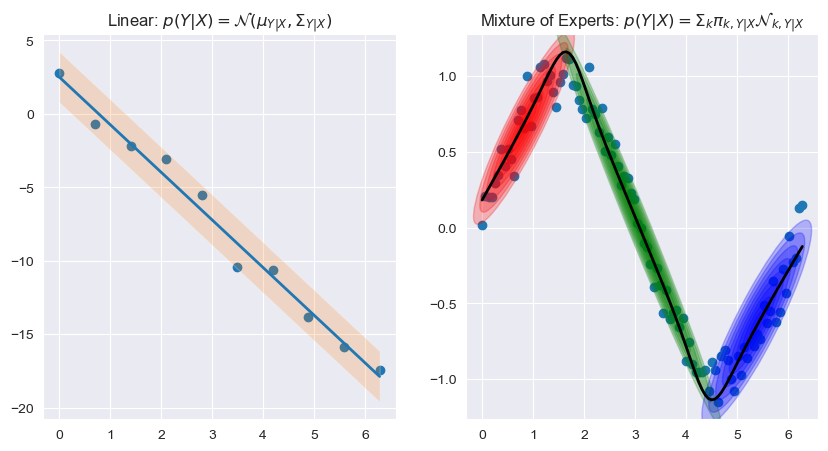

In [3]:
from sklearn.mixture import GaussianMixture
from gmr import GMM
import numpy as np
import matplotlib.pyplot as plt
from gmr.utils import check_random_state
from gmr import MVN, GMM, plot_error_ellipses


random_state = check_random_state(0)

n_samples = 10
X = np.ndarray((n_samples, 2))
X[:, 0] = np.linspace(0, 2 * np.pi, n_samples)
X[:, 1] = 1 - 3 * X[:, 0] + random_state.randn(n_samples)

mvn = MVN(random_state=0)
mvn.from_samples(X)

X_test = np.linspace(0, 2 * np.pi, 100)
mean, covariance = mvn.predict(np.array([0]), X_test[:, np.newaxis])

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Linear: $p(Y | X) = \mathcal{N}(\mu_{Y|X}, \Sigma_{Y|X})$")
plt.scatter(X[:, 0], X[:, 1])
y = mean.ravel()
s = 1.96 * np.sqrt(covariance.ravel())  # interval covers 95% of the data
plt.fill_between(X_test, y - s, y + s, alpha=0.2)
plt.plot(X_test, y, lw=2)

n_samples = 100
X = np.ndarray((n_samples, 2))
X[:, 0] = np.linspace(0, 2 * np.pi, n_samples)
X[:, 1] = np.sin(X[:, 0]) + random_state.randn(n_samples) * 0.1

gmm = GMM(n_components=3, random_state=0)
gmm.from_samples(X)
Y = gmm.predict(np.array([0]), X_test[:, np.newaxis])

plt.subplot(1, 2, 2)
plt.title("Mixture of Experts: $p(Y | X) = \Sigma_k \pi_{k, Y|X} "
          "\mathcal{N}_{k, Y|X}$")
plt.scatter(X[:, 0], X[:, 1])
plot_error_ellipses(plt.gca(), gmm, colors=["r", "g", "b"])
plt.plot(X_test, Y.ravel(), c="k", lw=2)

plt.show()

# Bayesian Gaussian Mixture Regression with PyMC3

In [4]:
import os
import warnings
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import xarray as xr

RANDOM_SEED = 42

## Bayesian Mixtures of Linear Regression Models 
Here we define the model $Y_{ij}=X_{ij}\beta_j + \epsilon_{ij}$ 


In [3]:
# Generate data
def GenerateData(n_compo = list(), N_components=2):
    # Parameters for the two linear regression models
    b = list()
    a = list()
    for i in range(N_components):
        b.append(np.random.uniform(0, 50, size=(1, 1)))  # slopes
        a.append(np.random.uniform(-10, 10, size=(1, 1)))   # intercepts
    sigma = 0.01   # standard deviation for the noise
    X = list()
    for i in range(N_components):
        X.append(np.random.uniform(-10, 10, size=(n_compo[i], 1)))
    e = list()
    for i in range(N_components):
        e.append(np.random.normal(0, sigma, size=(n_compo[i], 1)))
    Y = list()
    for i in range(N_components):
        Y.append(b[i] * X[i] + a[i] + e[i])
    X = np.vstack(X)
    Y = np.vstack(Y).ravel()
    return X, Y

n_compo = [100, 100, 100]


In [4]:
# Dataset 1
df = pd.read_csv('mixture.csv')
X = df['X'].values[:, None]
Y = df['Y'].values
 # Set k to small value for testing

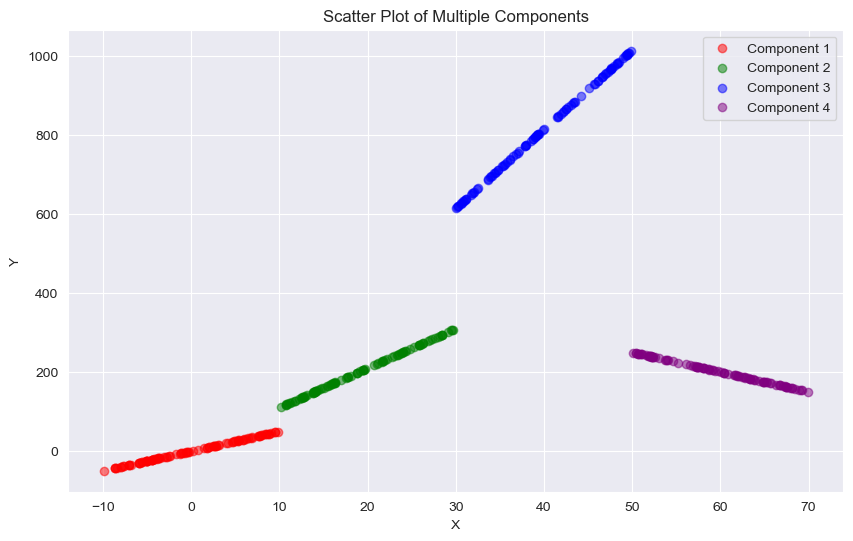

In [2]:
# Dataset 2
# Another example of linear regression model with two components
# Update n to 1000 for the new data generation
n = 1000
N_components = 4
# Parameters for the two linear regression models
b = [5, 10, 20, -5]  # slopes
a = [0, 10, 15, 500]   # intercepts
#b = [5, 10]
#a = [0, 10]
n = 100       # number of samples
sigma = 0.01   # standard deviation for the noise
k=4 #number of components
X = list()
for i in range(N_components):
    X.append(np.random.uniform(-10+20*i, 10+20*i, size=(n, 1)))
# Generate X values for the first 500 samples and second 500 samples separately
#X1 = np.random.uniform(-10, 10, size=(100, 1))
#X2 = np.random.uniform(-10, 10, size=(100, 1))
#X3 = np.random.uniform(-10, 10, size=(100, 1))
#X4 = np.random.uniform(-10, 10, size=(100, 1))

# Generate noise
e = list()
for i in range(N_components):
    e.append(np.random.normal(0, sigma, size=(n, 1)))
#e1 = np.random.normal(0, sigma, size=(100, 1))
#e2 = np.random.normal(0, sigma, size=(100, 1))
#e3 = np.random.normal(0, sigma, size=(100, 1))
#e4 = np.random.normal(0, sigma, size=(100, 1))
Y = list()
for i in range(N_components):
    Y.append(b[i] * X[i] + a[i] + e[i])
# Generate Y values based on two different linear regressions

plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue', 'purple']
for i in range(N_components):
    X_component = X[i]
    Y_component = Y[i]
    
    # Scatter plot for each component
    plt.scatter(X_component, Y_component, color=colors[i], alpha=0.5, label=f'Component {i+1}')

plt.title('Scatter Plot of Multiple Components')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

X = np.vstack(X)
Y = np.vstack(Y).ravel()
 
#Y1 = b[0] * X1 + a[0] + e1
#Y2 = b[1] * X2 + a[1] + e2
#Y1 =  b[0] + e1
#Y2 =  b[1] + e2

# Combine the data into a single DataFrame
#X = np.vstack([X1, X2])
#Y = np.vstack([Y1, Y2]).ravel()

#Plot x and y by different groups


In [9]:
# Dataset 3
n_samples = 100
random_state = np.random.RandomState(42)
X = np.ndarray((n_samples, 2))
X = np.linspace(0, 2 * np.pi, n_samples)
Y = np.sin(X) + random_state.randn(n_samples) * 0.1
k = 3


The model is defined as follows:
$$\pi_i \sim Dirichlet(k)$$
$$\alpha_i \sim Normal(0, 100)$$
$$\beta_i \sim Normal(0, 100)$$
$$\sigma_i \sim HalfCauchy(5)$$

$$\mu_{i} = \alpha_{i} + \beta_{i} X$$
$$Y|X, \alpha, \beta, \sigma, \pi \sim \Sigma_{i}^{k}\pi_i Normal(\mu_i, \sigma_i)$$

In [10]:
#With dirichlet distribution
with pm.Model() as Mixture_regression1:
    # Priors for weight parameter
    π_unsorted = pm.Dirichlet('π_unsorted', np.array([1]*k), initval=np.ones(k)/k) # Component weights
    π = pm.Deterministic('π', pt.sort(π_unsorted))
    
    # Priors for unknown model parameters
    α = pm.Normal('α', mu=0, sigma=100, shape=(1, k)) #Intercept
    β = pm.Normal('β', mu=0, sigma=100, shape=(1, k))
    #α = pm.Deterministic('α', pt.sort(α_unsorted))
    #β = pm.Deterministic('β', pt.sort(β_unsorted))
    σ  = pm.HalfCauchy('σ', 5, shape=k)  #Noise
    
    mu = α + β*X
    #try other likelihood
    likelihood = pm.NormalMixture('likelihood', π, mu, sigma=σ, observed=Y)
    trace = pm.sample(tune=2500,
            init="advi",
            target_accept=0.975,
            random_seed=RANDOM_SEED,)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Output()

Finished [100%]: Average Loss = 1,074.1
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [π_unsorted, α, β, σ]


Output()

Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 1104 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


The model is defined as follows:
$$ \alpha \sim Gamma(1,5)$$
$$ \beta \sim Beta(1, \alpha)$$
$$ \pi_i \sim \beta_i\Pi_{j=1}^{i-1}(1-\beta_j)$$

$$a_i \sim N(0,100)$$
$$b_i \sim N(0,100)$$
$$\mu_{i} = a_{i} + b_{i} X$$
$$\sigma_i \sim HalfCauchy(1)$$
$$Y|X, \alpha, \beta, \sigma, \pi \sim \Sigma_{i}^{k}\pi_i Normal(\mu_i, \sigma_i)$$

In [12]:
def stick_breaking(beta):
    portion_remaining = pt.concatenate([[1], pt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

In [13]:
def reparameterize(pi):
    return pi / pi.sum()

In [14]:
#Dirichlet Process Gaussian Mixture Model
with pm.Model(coords={"component": np.arange(k)}) as Mixture_regression2:
    # Priors for weight parameter
    alpha = pm.Gamma("alpha", 1.0, 5.0)
    beta = pm.Beta("beta", 1.0, alpha, dims="component") # Generate beta values
    π = pm.Deterministic("π", stick_breaking(beta), dims="component")  # Component weights
    π1_us = pm.Deterministic("π1_us", reparameterize(π), dims="component")  # Component weights
    π1 = pm.Deterministic("π1", pt.sort(π1_us), dims="component")  # Component weights
    
    # Priors for unknown model parameters
    α = pm.Normal('α', mu=0, sigma=100, shape=(1, k)) #Intercept
    β = pm.Normal('β', mu=0, sigma=100, shape=(1, k))
    #α = pm.Deterministic('α', pt.sort(α_us))
    #β = pm.Deterministic('β', pt.sort(β_us))
    
    σ  = pm.HalfCauchy('σ', 1, shape=k)  #Noise
    
    mu = α + β*X
    #mu = α    
    likelihood = pm.NormalMixture('likelihood', π1, mu, sigma=σ, observed=Y)
    trace = pm.sample(
            tune=2500,
            init="advi",
            target_accept=0.975,
            random_seed=RANDOM_SEED,
        )

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Output()

Convergence achieved at 31900
Interrupted at 31,899 [15%]: Average Loss = 1.4107e+06
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, α, β, σ]


Output()

Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 1403 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [7]:
#Summary of the model
#
def summary(trace, model, type="DirichletProcess"):
    if type == "DirichletProcess":
        print(az.summary(trace, var_names=["α", "β", "π", "π1", "σ"]))
    elif type == "DirichletDistribution":
        print(az.summary(trace, var_names=["α", "β", "π", "σ"]))
    
    print("True values: a", a, "b", b)
    az.plot_trace(trace)
    with model:
        posterior_predictive = pm.sample_posterior_predictive(trace, random_seed=RANDOM_SEED)
    az.plot_posterior(trace, var_names=["α", "β", "σ", "π"])
    fig, ax = plt.subplots(figsize=(8, 6))

    plot_w = np.arange(k) + 1
    
    ax.bar(plot_w - 0.5, trace.posterior["π"].mean(("chain", "draw")), width=1.0, lw=0)
    
    ax.set_xlim(0.5, k)
    ax.set_xlabel("Component")
    
    ax.set_ylabel("Posterior expected mixture weight");


            mean       sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
α[0, 0]   -0.000    0.000  -0.001    0.001      0.000    0.000       6.0   
α[0, 1]  377.502  212.202   9.995  500.021    105.676   80.914       7.0   
α[0, 2]  133.245  211.780   9.468  500.036    105.465   80.753       5.0   
α[0, 3]   14.992    0.007  14.983   15.003      0.003    0.003       5.0   
β[0, 0]    5.000    0.000   5.000    5.000      0.000    0.000       8.0   
β[0, 1]   -1.250    6.496  -5.000   10.000      3.235    2.477       7.0   
β[0, 2]    6.210    6.474  -5.001   10.026      3.224    2.468       5.0   
β[0, 3]   20.000    0.000  20.000   20.000      0.000    0.000       5.0   
π[0]       0.223    0.014   0.199    0.244      0.006    0.005       5.0   
π[1]       0.242    0.009   0.221    0.256      0.004    0.003       5.0   
π[2]       0.258    0.008   0.242    0.273      0.003    0.002       7.0   
π[3]       0.277    0.015   0.257    0.307      0.007    0.005       5.0   
σ[0]       0

Sampling: [likelihood]


Output()

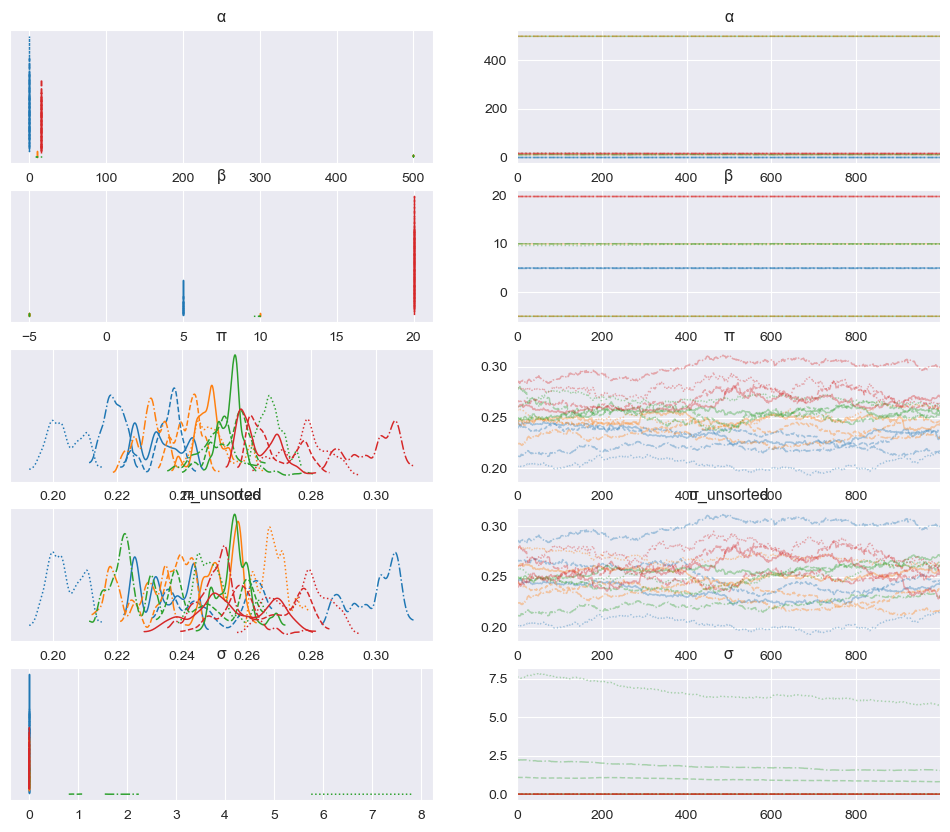

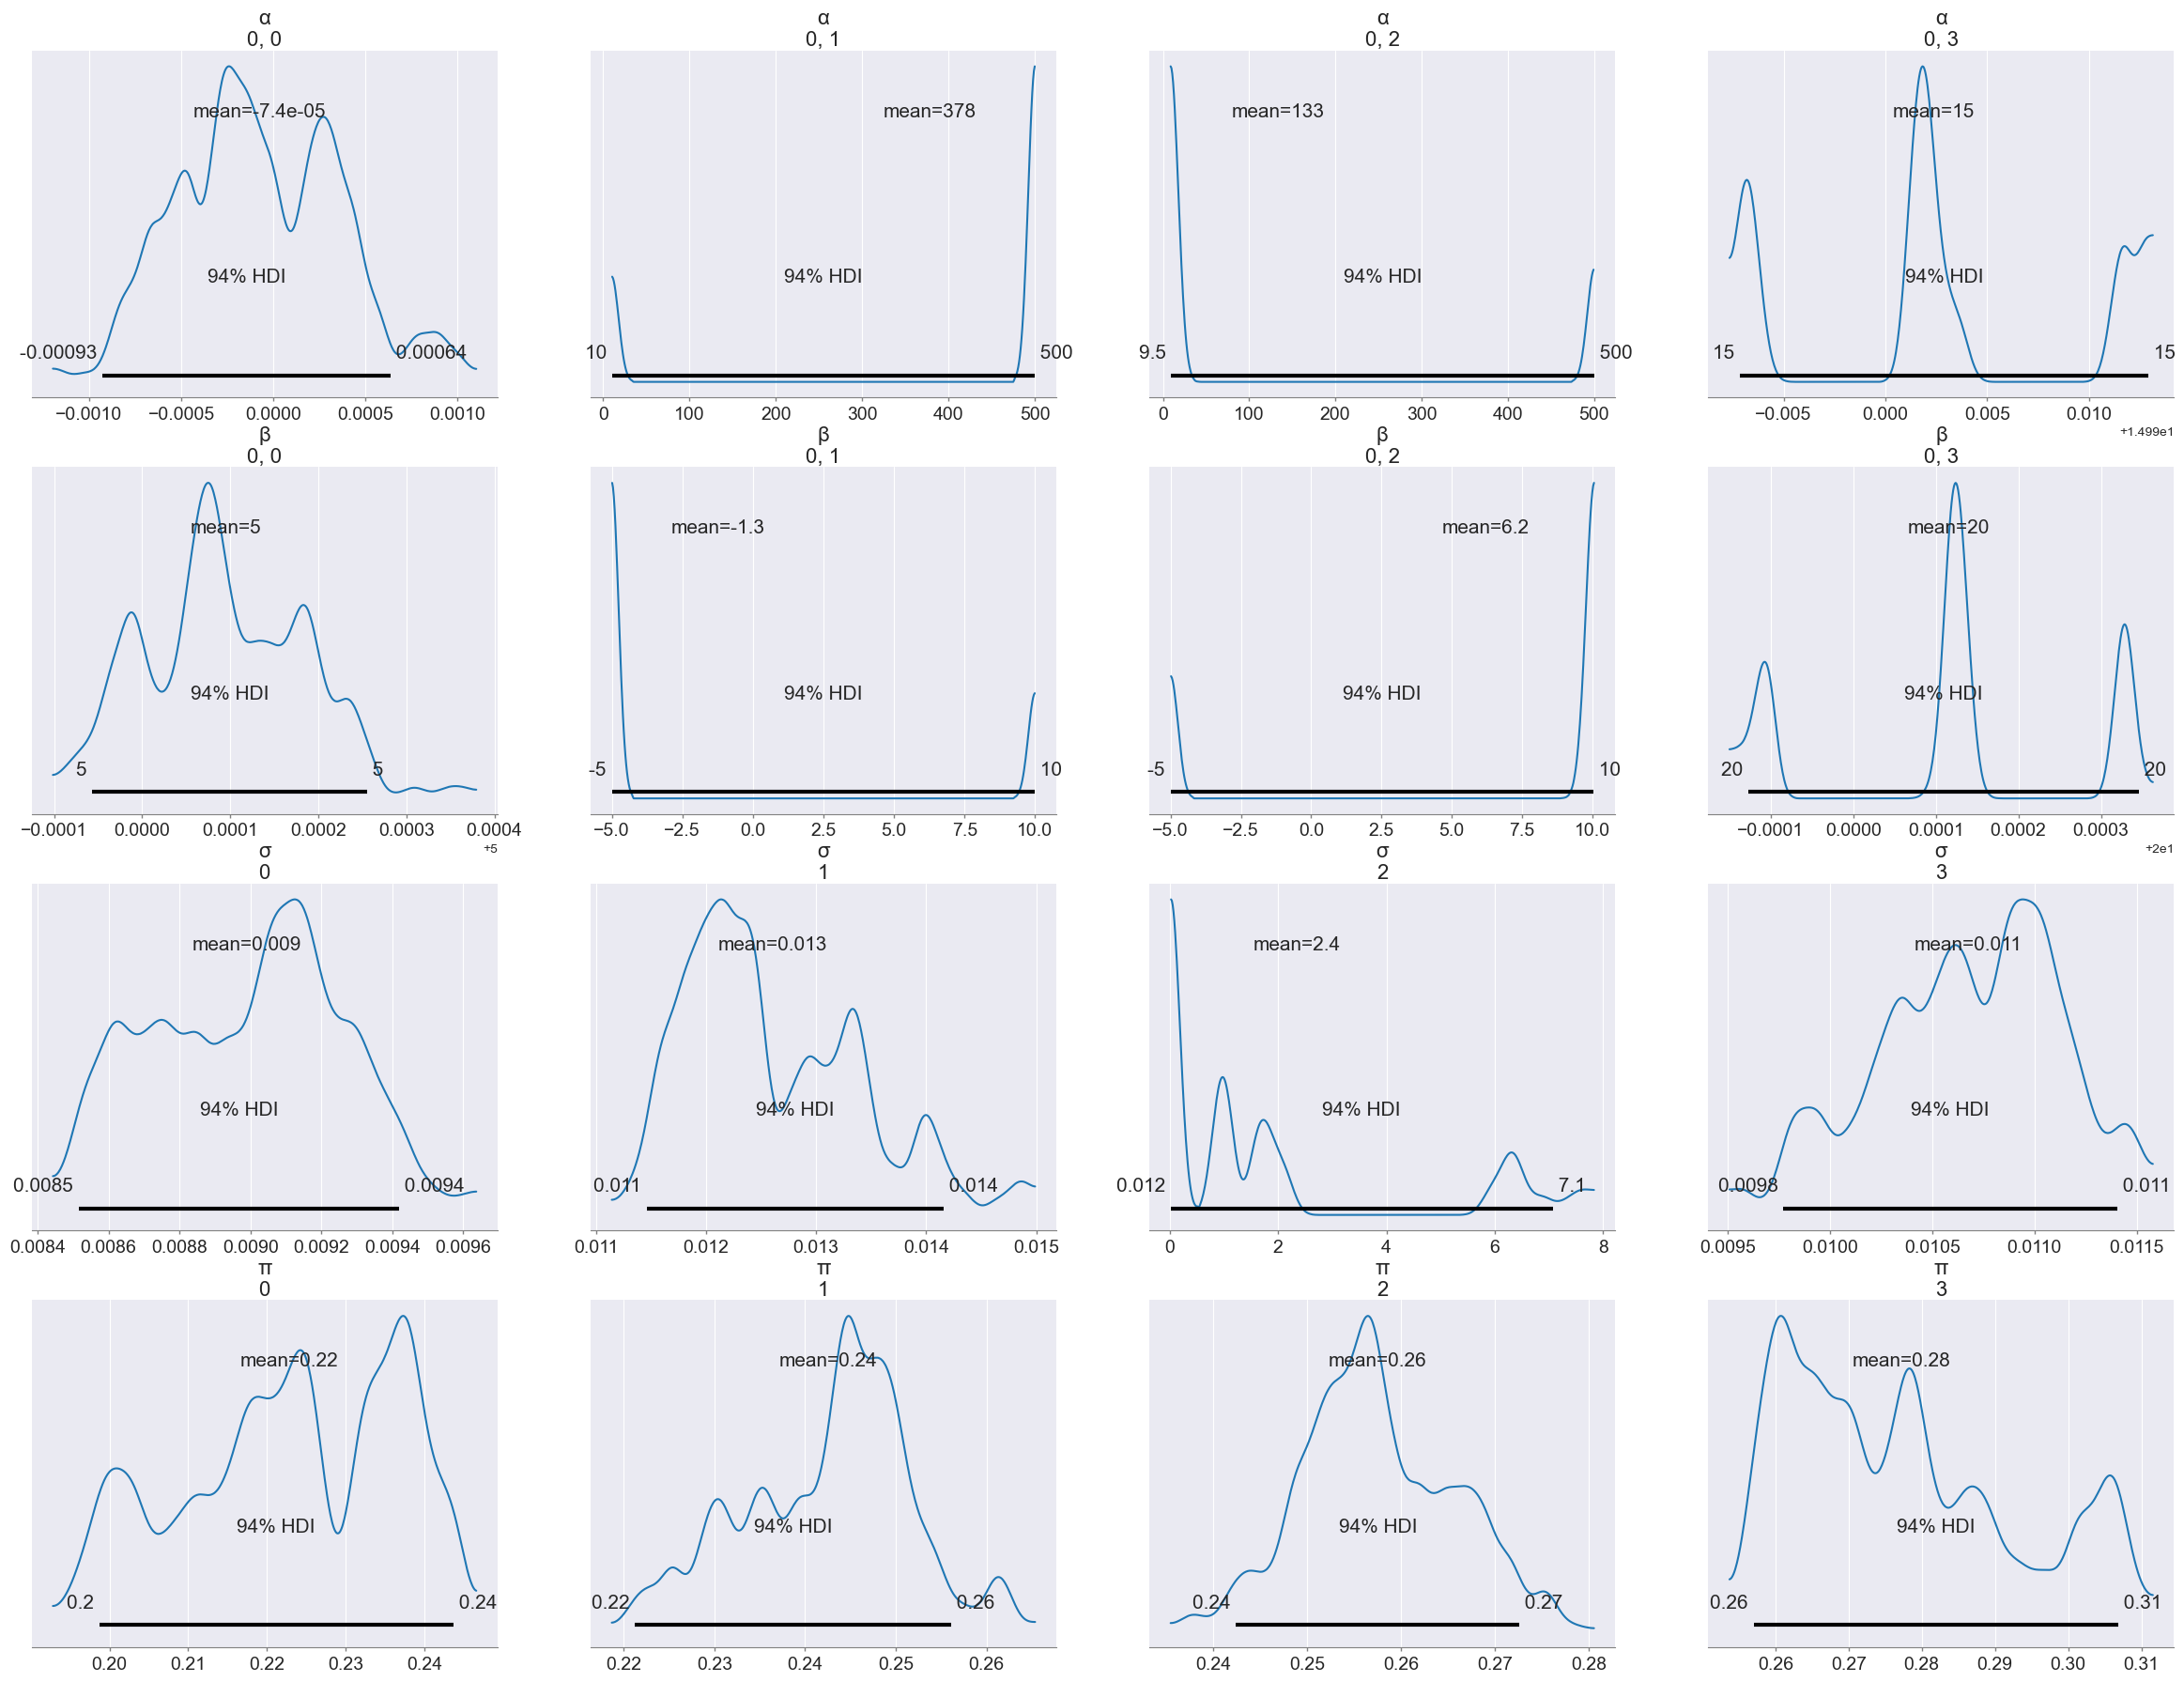

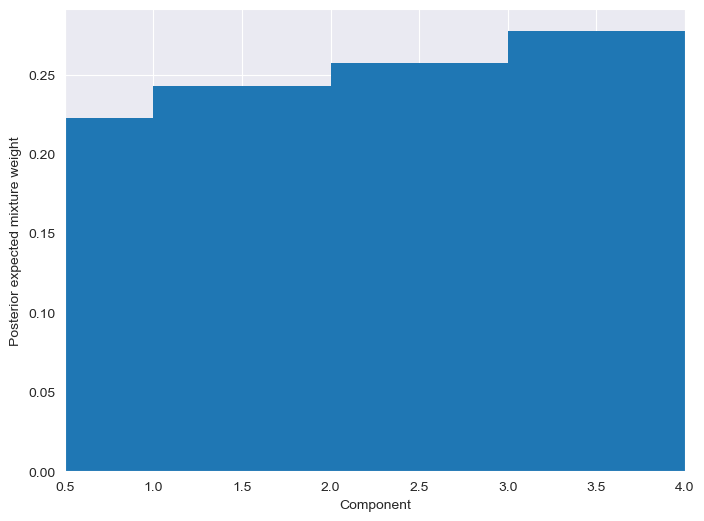

In [11]:
summary(trace, Mixture_regression1, type="DirichletDistribution")

           mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
α[0, 0]   9.817   5.522   1.573   15.016      2.749    2.105       5.0   
α[0, 1]   1.678   1.760  -0.004    4.229      0.873    0.668       5.0   
α[0, 2]   7.332   5.320  -0.002   15.002      2.649    2.028       5.0   
α[0, 3]   6.614   6.105  -0.002   15.002      3.040    2.328       5.0   
β[0, 0]  11.707   8.313   2.585   20.001      4.140    3.170       5.0   
β[0, 1]   4.458   0.575   3.561    5.001      0.283    0.216       5.0   
β[0, 2]   8.292   6.772   3.846   20.001      3.372    2.582       5.0   
β[0, 3]   8.250   6.800   3.668   20.001      3.386    2.593       4.0   
π[0]      0.195   0.081   0.054    0.275      0.040    0.031       5.0   
π[1]      0.285   0.105   0.181    0.471      0.052    0.040       5.0   
π[2]      0.247   0.018   0.211    0.269      0.009    0.007       5.0   
π[3]      0.250   0.019   0.220    0.283      0.009    0.007       5.0   
π1[0]     0.180   0.073   0.055    0.2

Sampling: [likelihood]


Output()

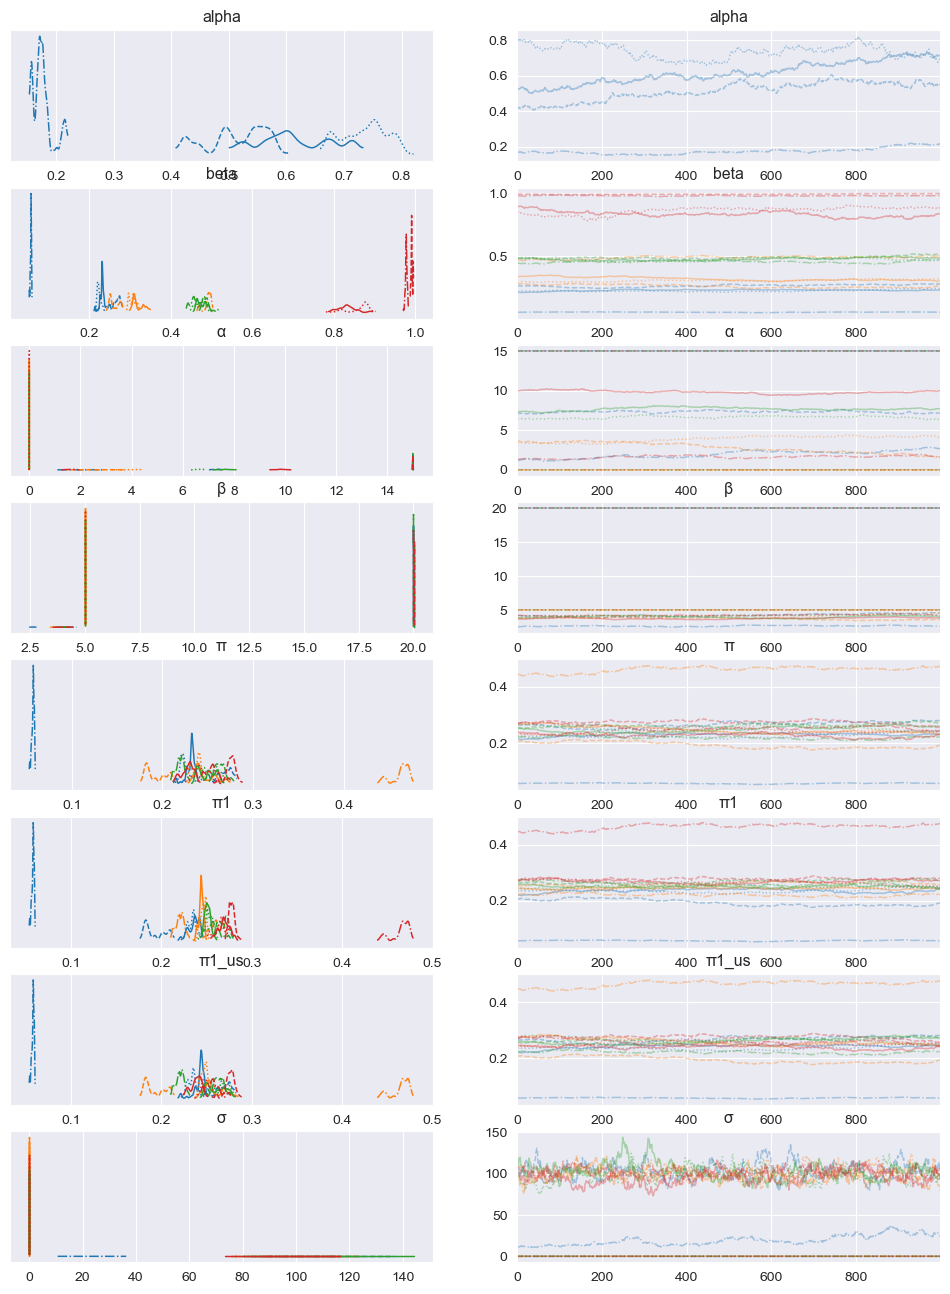

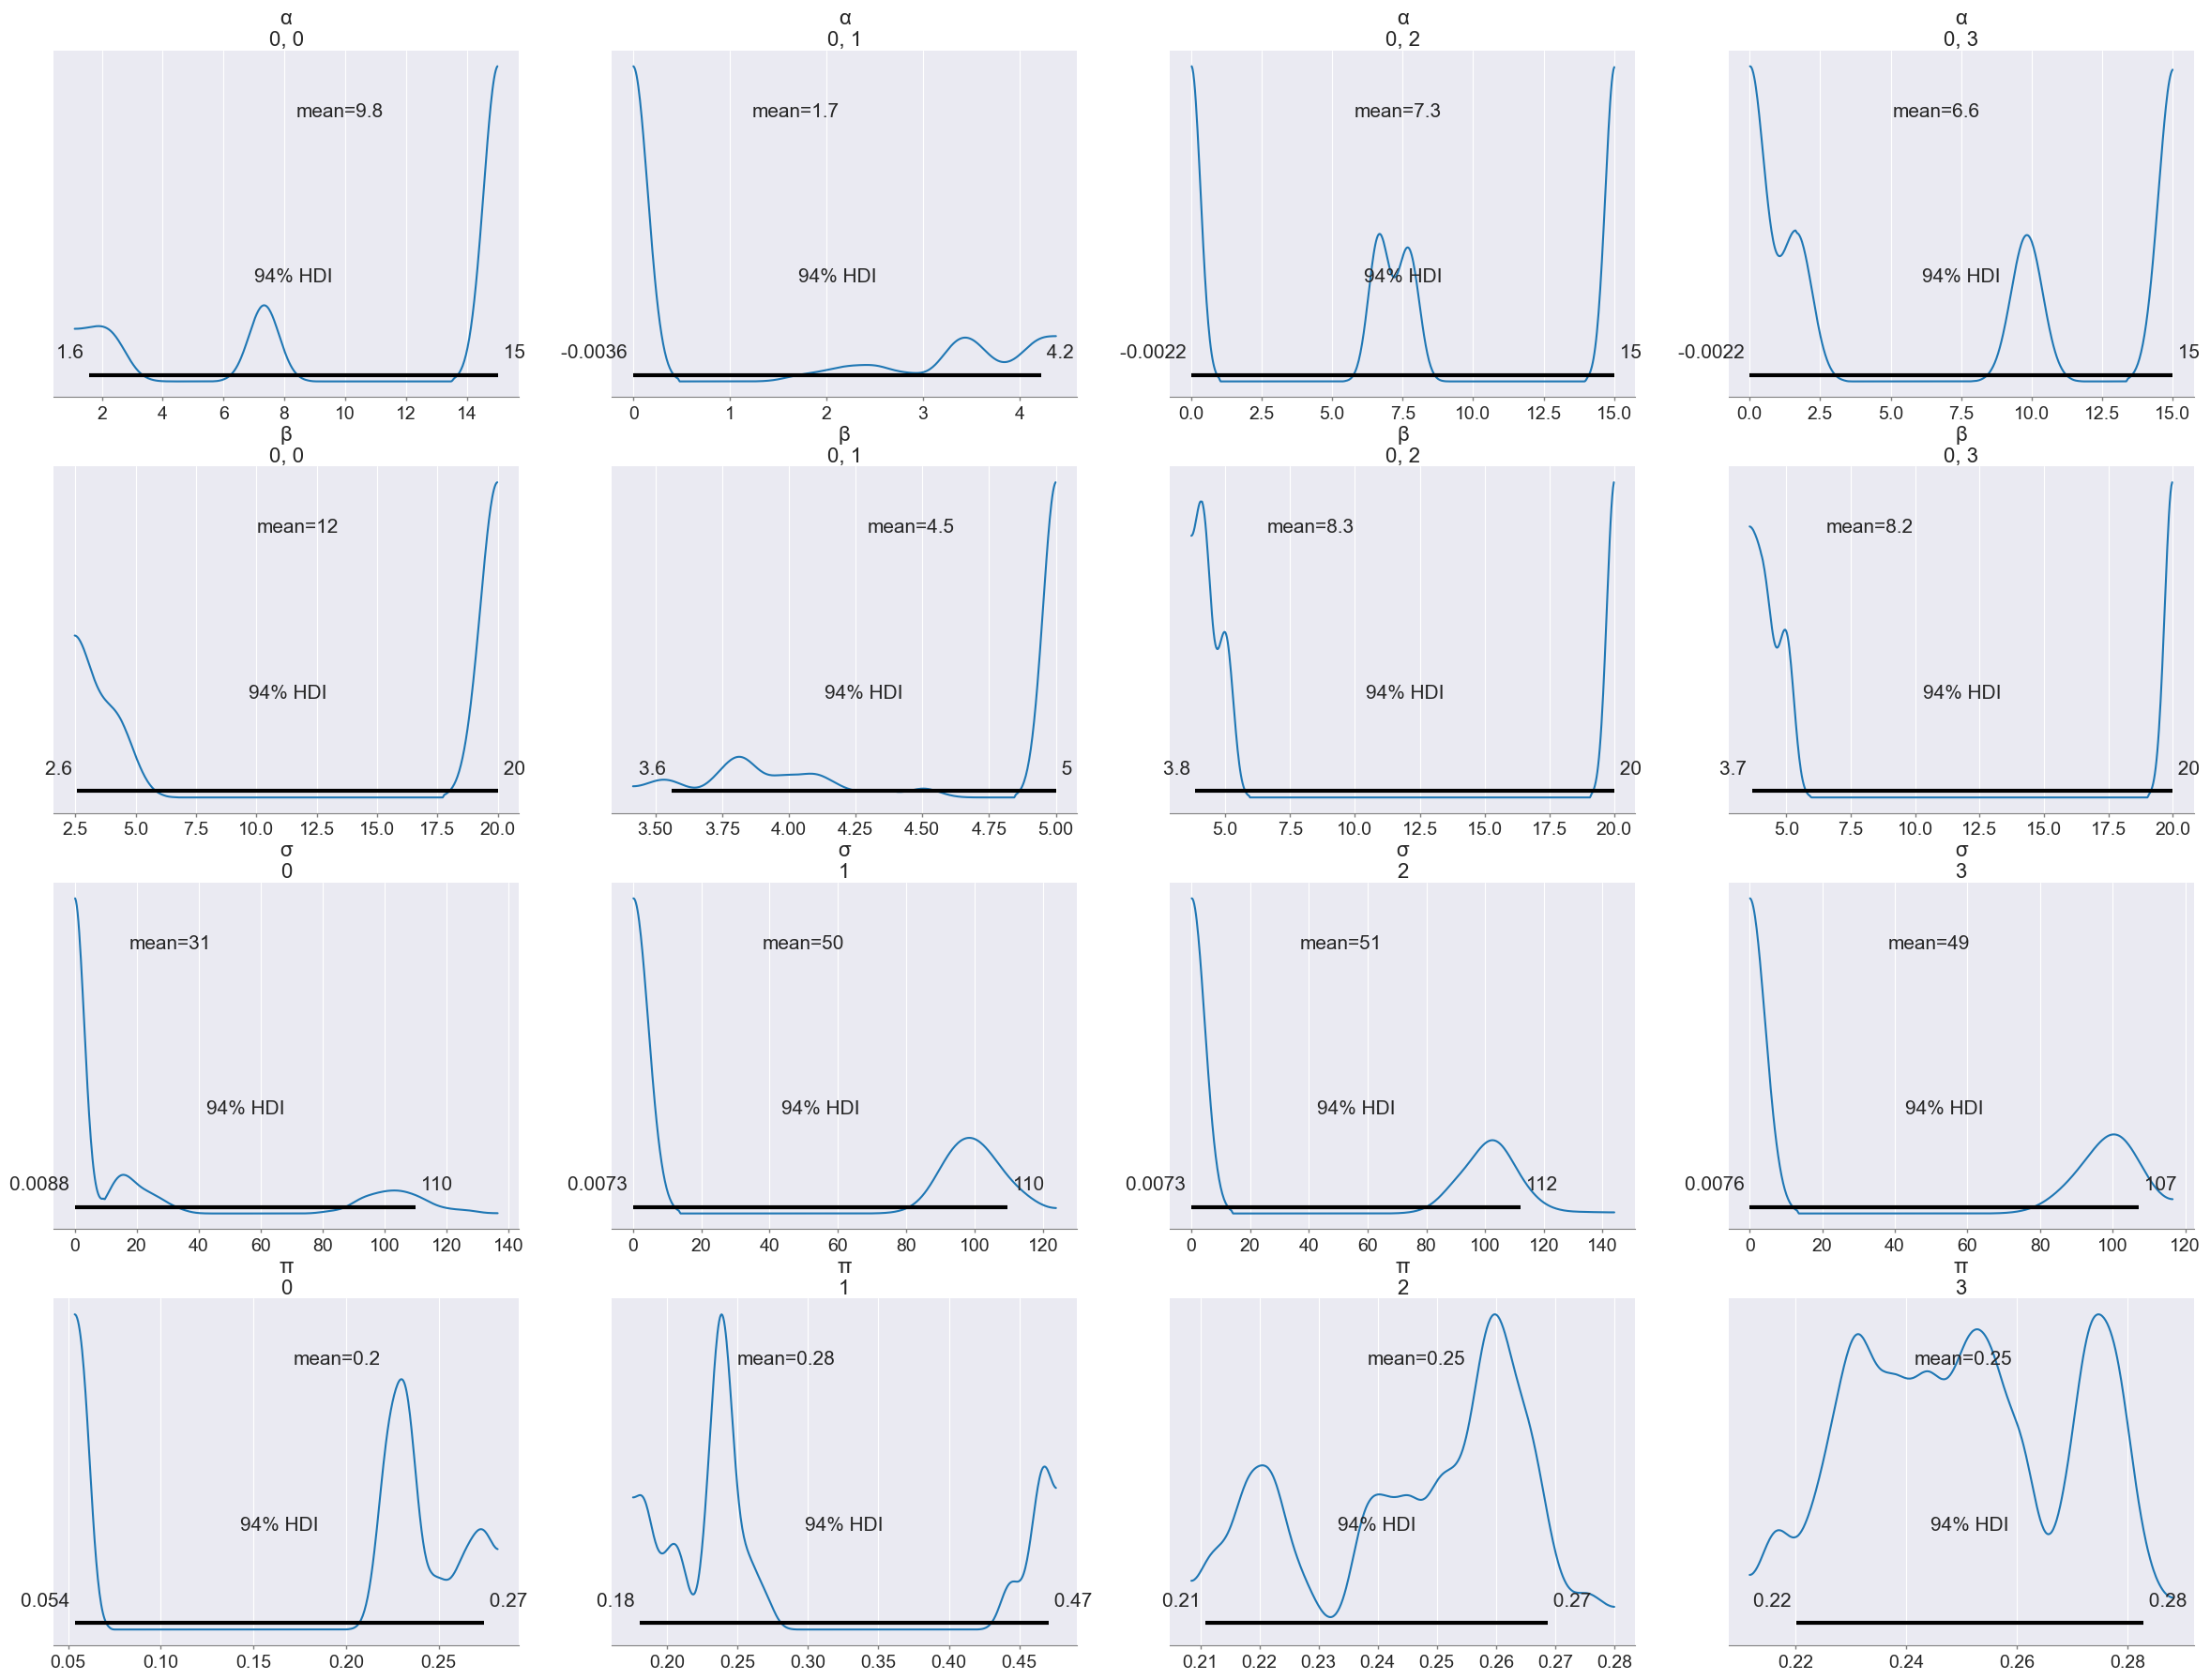

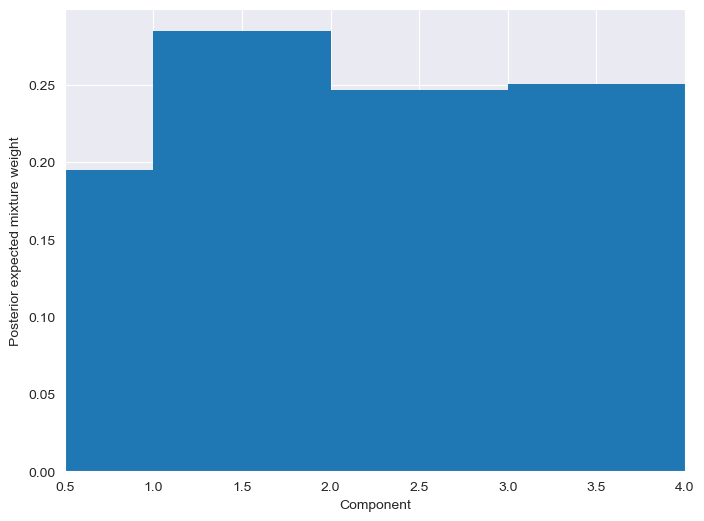

In [15]:
summary(trace, Mixture_regression2, type="DirichletProcess")

## Customised Likelihood Function

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

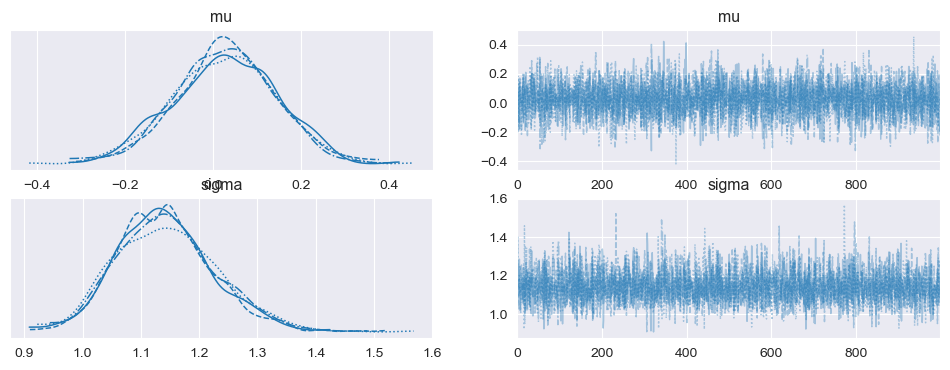

In [53]:
#
y_obs = np.random.normal(loc=5.0, scale=2.0, size=100)
def custom_likelihood(value, mu, sigma):
    # Custom likelihood: assume it's a normal distribution for this example
    logp = -0.5 * pt.sum((value - mu) ** 2 / sigma ** 2 + pt.log(2 * np.pi * sigma ** 2))
    return logp

# Generate some fake data
np.random.seed(123)
data = np.random.normal(0, 1, size=100)

# Build the PyMC model
with pm.Model() as model:
    # Define prior distributions for parameters
    mu = pm.Normal('mu', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Define custom likelihood using CustomDist
    custom = pm.CustomDist('custom_likelihood',
                           mu, sigma,
                           logp=custom_likelihood,
                           observed=data)

    # Inference: run sampling
    trace = pm.sample(1000, return_inferencedata=True)

# Plot and analyze the trace
pm.plot_trace(trace)

## Interpolated Likelihood
Here we define a custom likelihood function that is interpolated from a set of sampled x and likelihood values. The likelihood is assumed to be a $N(0,1)$ distribution for this example. 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

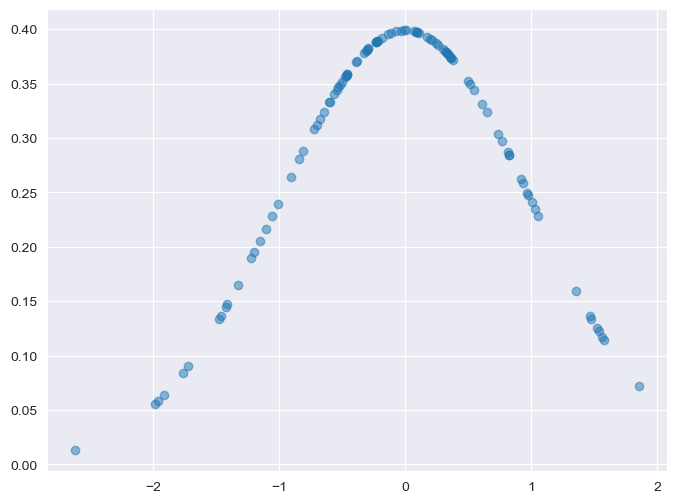

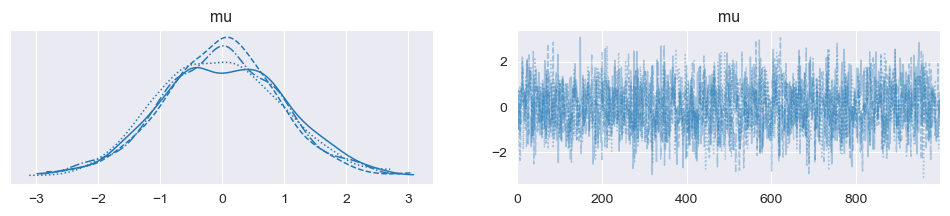

In [41]:

# Generate some fake observed data
np.random.seed(42)
observed_mu = np.random.normal(0, 1, size=100)
#reorder the observed mu
observed_mu = np.sort(observed_mu)

# Generate some fake observed data and exclude values that exceed the observed mu or less than min observed mu
observed_data = np.random.normal(0, 1, size=30)
observed_data = observed_data[(observed_data < observed_mu.max()) & (observed_data > observed_mu.min())]



# Precompute log-likelihoods for different values of mu (assuming normal likelihood)
log_likelihood_values = -0.5 * (observed_mu[:, None]) ** 2 - 0.5 * np.log(2 * np.pi) 
sampled_likelihood = np.exp(log_likelihood_values)

#plot the scatter likelihood values
plt.figure(figsize=(8, 6))
plt.scatter(observed_mu, np.exp(log_likelihood_values), alpha=0.5)

# Build the PyMC model
with pm.Model() as model:
    # Define a prior for mu: N(0, 1)
    mu = pm.Normal('mu', mu=0, sigma=1)
    
    # use interpolation to get the log-likelihood for the observed data
    log_likelihood = pm.Interpolated('log_likelihood', observed_mu, sampled_likelihood, observed=observed_data)
    

    # Perform MCMC sampling
    trace = pm.sample(1000, return_inferencedata=True)




# Plot the trace
pm.plot_trace(trace)

In [ ]:
from pytensor.graph import Apply, Op
from scipy.optimize import approx_fprime

def my_model(m, c, x):
    return m * x + c


def my_loglike(m, c, sigma, x, data):
    # We fail explicitly if inputs are not numerical types for the sake of this tutorial
    # As defined, my_loglike would actually work fine with PyTensor variables!
    for param in (m, c, sigma, x, data):
        if not isinstance(param, (float, np.ndarray)):
            raise TypeError(f"Invalid input type to loglike: {type(param)}")
    model = my_model(m, c, x)
    return -0.5 * ((data - model) / sigma) ** 2 - np.log(np.sqrt(2 * np.pi)) - np.log(sigma)

class LogLike(Op):
    def make_node(self, m, c, sigma, x, data) -> Apply:
        # Convert inputs to tensor variables
        m = pt.as_tensor(m)
        c = pt.as_tensor(c)
        sigma = pt.as_tensor(sigma)
        x = pt.as_tensor(x)
        data = pt.as_tensor(data)

        inputs = [m, c, sigma, x, data]
        # Define output type, in our case a vector of likelihoods
        # with the same dimensions and same data type as data
        # If data must always be a vector, we could have hard-coded
        # outputs = [pt.vector()]
        outputs = [data.type()]

        # Apply is an object that combines inputs, outputs and an Op (self)
        return Apply(self, inputs, outputs)

    def perform(self, node: Apply, inputs: list[np.ndarray], outputs: list[list[None]]) -> None:
        # This is the method that compute numerical output
        # given numerical inputs. Everything here is numpy arrays
        m, c, sigma, x, data = inputs  # this will contain my variables

        # call our numpy log-likelihood function
        loglike_eval = my_loglike(m, c, sigma, x, data)

        # Save the result in the outputs list provided by PyTensor
        # There is one list per output, each containing another list
        # pre-populated with a `None` where the result should be saved.
        outputs[0][0] = np.asarray(loglike_eval)

In [9]:
# set up our data
N = 10  # number of data points
sigma = 1.0  # standard deviation of noise
x = np.linspace(0.0, 9.0, N)

mtrue = 0.4  # true gradient
ctrue = 3.0  # true y-intercept

truemodel = my_model(mtrue, ctrue, x)

# make data
rng = np.random.default_rng(716743)
data = sigma * rng.normal(size=N) + truemodel

In [10]:
# create our Op
loglike_op = LogLike()

test_out = loglike_op(mtrue, ctrue, sigma, x, data)

In [11]:
test_out.eval()

array([-1.1063979 , -0.92587551, -1.34602737, -0.91918325, -1.72027674,
       -1.2816813 , -0.91895074, -1.02783982, -1.68422175, -1.45520871])

In [12]:
def custom_dist_loglike(data, m, c, sigma, x):
    # data, or observed is always passed as the first input of CustomDist
    return loglike_op(m, c, sigma, x, data)


# use PyMC to sampler from log-likelihood
with pm.Model() as no_grad_model:
    # uniform priors on m and c
    m = pm.Uniform("m", lower=-10.0, upper=10.0, initval=mtrue)
    c = pm.Uniform("c", lower=-10.0, upper=10.0, initval=ctrue)

    # use a CustomDist with a custom logp function
    likelihood = pm.CustomDist(
        "likelihood", m, c, sigma, x, observed=data, logp=custom_dist_loglike
    )

In [13]:
ip = no_grad_model.initial_point()
ip

{'m_interval__': array(0.08004271), 'c_interval__': array(0.61903921)}

In [14]:
no_grad_model.compile_logp(vars=[likelihood], sum=False)(ip)

[array([-1.1063979 , -0.92587551, -1.34602737, -0.91918325, -1.72027674,
        -1.2816813 , -0.91895074, -1.02783982, -1.68422175, -1.45520871])]

In [15]:
try:
    no_grad_model.compile_dlogp()
except Exception as exc:
    print(type(exc))

<class 'NotImplementedError'>


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [m]
>Slice: [c]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 23 seconds.


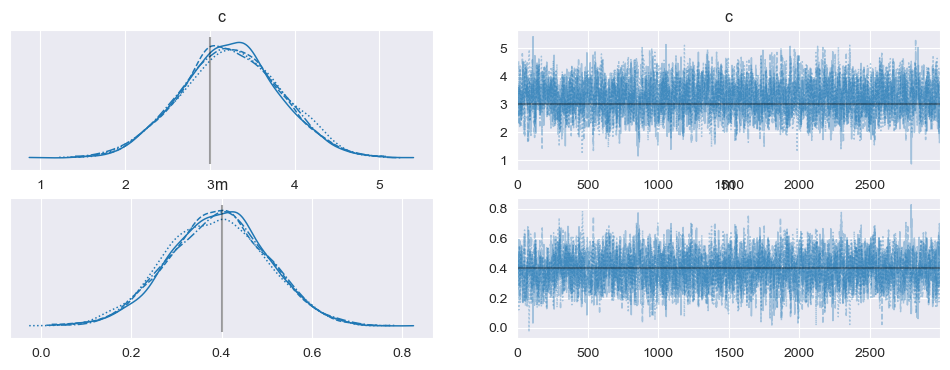

In [16]:
with no_grad_model:
    # Use custom number of draws to replace the HMC based defaults
    idata_no_grad = pm.sample(3000, tune=1000)

# plot the traces
az.plot_trace(idata_no_grad, lines=[("m", {}, mtrue), ("c", {}, ctrue)]);